In [1]:
import base64
import json
import os

import qdrant_client
import dotenv
import matplotlib.pyplot as plt
import tqdm
from PIL import Image
import torch
import clip

from llama_index.core import PromptTemplate
from llama_index.core import SimpleDirectoryReader, Document, StorageContext
from llama_index.core.indices import VectorStoreIndex
from llama_index.core.vector_stores import VectorStoreQuery
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core.schema import ImageDocument
from llama_index.core.schema import TextNode, ImageNode
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index.core.node_parser import SentenceSplitter
from llama_index.embeddings.openai import OpenAIEmbedding
from openai import OpenAI

In [2]:
OPENAI_API_KEY = dotenv.get_key(dotenv.find_dotenv(), "OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
device = "cuda" if torch.cuda.is_available() else "cpu"
load_previously_generated_text_descriptions = True
dataset_path = './Flickr8k_text'
output_path = 'flickr.json'

path_to_images = f"Flicker8k_Dataset"
path_to_text = f"Flickr8k_text"

In [14]:
QA_FLICKR_TEMPLATE_STR = (
    "Images of events are provided.\n"

    "Using the images as context, answer the following queries.\n"
    "provide an answer to the query.\n"
    "Query: {query_str}\n"
    "Answer: "
)
QA_TEMPLATE_STR = (
    "provide an answer to the query.\n"
    "Query: {query_str}\n"
    "Answer: "
)

In [4]:
# local qdrant client
qdrant_client = qdrant_client.QdrantClient(path="mm_qdrant_db")
img_text_store = QdrantVectorStore(
    client=qdrant_client, collection_name="text_to_image"
)

In [5]:
text_embedding = OpenAIEmbedding(model="text-embedding-3-large")
model, preprocess = clip.load("ViT-L/14", device=device)

In [ ]:
# define our lmm
openai_mm_llm = OpenAIMultiModal(
    model="gpt-4o", max_new_tokens=300
)

In [6]:
with open(f"{dataset_path}/image_descriptions.json") as f:
    image_descriptions = json.load(f)

image_to_text_document = [
    ImageDocument.from_dict(el) for el in image_descriptions
]

print(f"Number of image descriptions: {len(image_to_text_document)}")

# ImageDocument to TextDocument
img_text_document = []
img_text_paths = []
for img_doc in image_to_text_document:
    new_text_doc = Document(text=img_doc.text, metadata={"file_path": img_doc.metadata["file_path"]} )
    img_text_document.append(new_text_doc)
    img_text_paths.append(img_doc.metadata["file_path"])


Number of image descriptions: 1000


In [7]:
node_parser = SentenceSplitter.from_defaults()
image_text_nodes = node_parser.get_nodes_from_documents(image_to_text_document)
img_text_storage = StorageContext.from_defaults(vector_store=img_text_store)

In [8]:
img_text_index = VectorStoreIndex(
    nodes=image_text_nodes,
    storage_context=img_text_storage,
    embed_model=text_embedding
)

In [9]:
# text_retreiver
img_text_retriever = img_text_index.as_retriever(similarity_top_k=3)

In [10]:
def display_text_to_image_response(response, images):
    num_images = len(images)
    fig, ax = plt.subplots(1, num_images, figsize=(20, 20))
    
    for i, img_path in enumerate(images):
        img = Image.open(img_path)
        ax[i].imshow(img)
        ax[i].axis("off")
        
    plt.show()
    
    print("-------------------------")
    print("Response:")
    print(response)
    
    return

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

In [22]:
QUERY="Describe the ski on the snowy mountain."

In [23]:
QUERY_TEMPLATE = QA_FLICKR_TEMPLATE_STR.format(query_str=QUERY)

response_text_img = img_text_retriever.retrieve(QUERY)
text_imgs = list(map(lambda x: x.node.metadata["file_path"], response_text_img))
base64_text_imgs = list(map(lambda x: encode_image(x), text_imgs))

In [24]:
client = OpenAI()

In [25]:
text_img_response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": QUERY_TEMPLATE
                    },
                    *[
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/jpeg;base64,{base64_text_img}"
                            }
                        }
                        for base64_text_img in base64_text_imgs
                    ]
                ]
            }
        ],
    )

ANSWER = text_img_response.choices[0].message.content
print(ANSWER)

The images depict skiers navigating snowy mountain slopes. They all appear to be engaged in downhill skiing, capturing dynamic movement as they descend the slopes. Each skier is equipped with typical skiing gear: ski poles, skis, and helmets, emphasizing safety and control while descending. The snowy mountain terrain ranges from steep and challenging slopes to more open expanses, showcasing the diverse environments skiers can experience on a mountain. The skiers' stances suggest a mix of speed, confidence, and skill.


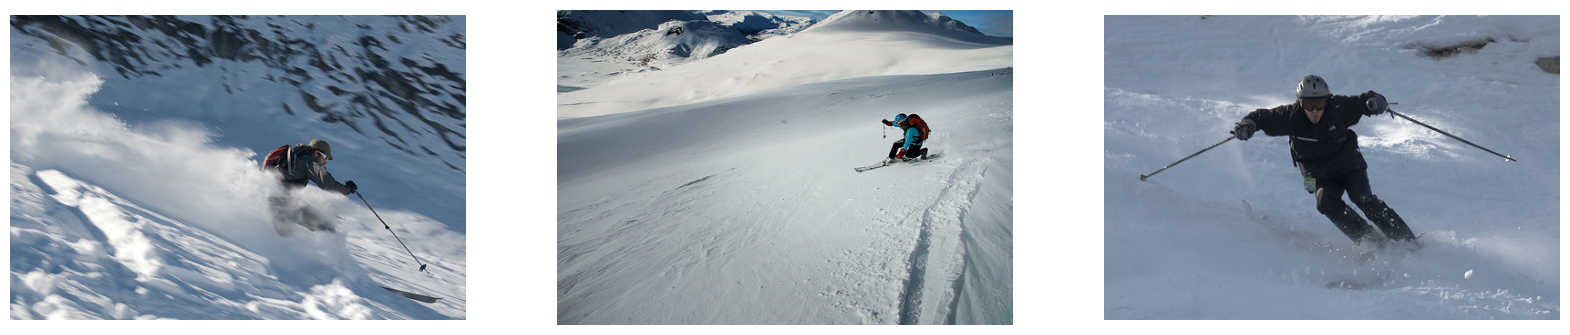

-------------------------
Response:
The images depict skiers navigating snowy mountain slopes. They all appear to be engaged in downhill skiing, capturing dynamic movement as they descend the slopes. Each skier is equipped with typical skiing gear: ski poles, skis, and helmets, emphasizing safety and control while descending. The snowy mountain terrain ranges from steep and challenging slopes to more open expanses, showcasing the diverse environments skiers can experience on a mountain. The skiers' stances suggest a mix of speed, confidence, and skill.


In [26]:
display_text_to_image_response(ANSWER, text_imgs)